In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

BASE_DIR = '/content/drive/MyDrive/AeroSound-FaultNet'
os.chdir(BASE_DIR)
print("Working directory:", os.getcwd())


Mounted at /content/drive
Working directory: /content/drive/MyDrive/AeroSound-FaultNet


In [2]:
!pip install -q tensorflow tensorflow-hub tensorflow-io librosa pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 122.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import os

manifests = 'data/manifests'

train_df = pd.read_csv(os.path.join(manifests, 'train.csv'))
val_df   = pd.read_csv(os.path.join(manifests, 'val.csv'))
test_df  = pd.read_csv(os.path.join(manifests, 'test.csv'))

print(len(train_df), len(val_df), len(test_df))


6557 1412 1402


In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import librosa
import numpy as np
import pandas as pd

# Load YAMNet
YAMNET_MODEL_HANDLE = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(YAMNET_MODEL_HANDLE)

label_map = {'healthy': 0, 'faulty': 1}

def load_wav_16k(path):
    """Load audio as 16k mono float32 numpy array. Raises if totally broken."""
    wav, sr = librosa.load(path, sr=16000, mono=True)
    wav = wav.astype(np.float32)
    if wav.size == 0:
        raise ValueError(f"Empty waveform: {path}")
    return wav

def wav_to_embedding(wav):
    """
    Convert waveform (1D np.array) -> 1024-dim embedding.
    Handles weird shapes defensively so training doesn't crash.
    """
    # YAMNet expects a tf.float32 tensor
    wav_tf = tf.convert_to_tensor(wav, dtype=tf.float32)

    scores, embeddings, spectrogram = yamnet(wav_tf)

    # Convert to numpy
    emb_np = embeddings.numpy()

    # Expected shape: [num_patches, 1024]
    if emb_np.ndim == 2 and emb_np.shape[1] == 1024:
        emb = emb_np.mean(axis=0)
    elif emb_np.ndim == 1 and emb_np.shape[0] == 1024:
        # Rare case: already a single 1024-d vector
        emb = emb_np
    else:
        # Fallback: don't blow up training; log and return zeros
        print(f"[WARN] Unexpected embedding shape {emb_np.shape}, using zeros instead.")
        emb = np.zeros(1024, dtype=np.float32)

    return emb.astype(np.float32)


In [5]:
import pandas as pd
import tensorflow as tf # Import tf for AUTOTUNE and other tf operations
import os # Import os for path manipulation

# Removed local BASE_DIR definition, relying on global and os.chdir

def make_dataset(csv_path_relative, batch=32, shuffle=True):
    # Rely on os.chdir from initial setup, use relative path directly
    df = pd.read_csv(csv_path_relative)
    paths = df['path'].tolist()
    labels = [label_map[x] for x in df['label']]

    base_ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    def _load_py(path, label):
        """
        Runs in Python via tf.py_function – can use librosa, numpy, etc.
        Must be defensive: skip / fix bad files instead of crashing.
        """
        path_str = path.numpy().decode("utf-8")

        try:
            wav = load_wav_16k(path_str)
            emb = wav_to_embedding(wav)
        except Exception as e:
            # If something goes wrong (corrupt file, etc.), fall back to zeros
            print(f"[WARN] Failed to process {path_str}: {e}")
            emb = np.zeros(1024, dtype=np.float32)

        return emb, np.int64(label)

    def wrapper(path, label):
        emb, lab = tf.py_function(
            _load_py, [path, label], [tf.float32, tf.int64]
        )
        emb.set_shape([1024])  # fix static shape for Keras
        lab.set_shape([])
        return emb, lab

    ds = base_ds.map(wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024)
    ds = ds.batch(batch).prefetch(tf.data.AUTOTUNE)
    return ds

# Pass relative paths, relying on the notebook's current working directory
train_ds = make_dataset('data/manifests/train.csv', batch=32, shuffle=True)
val_ds   = make_dataset('data/manifests/val.csv',   batch=32, shuffle=False)
test_ds  = make_dataset('data/manifests/test.csv',  batch=32, shuffle=False)

In [6]:
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import tensorflow as tf # Import tensorflow to access tf.nn for activations

# Custom Linear layer to bypass the problematic tf.keras.layers.Dense
class CustomLinear(layers.Layer):
    def __init__(self, units, kernel_regularizer=None, **kwargs):
        super(CustomLinear, self).__init__(**kwargs)
        self.units = units
        self.kernel_regularizer = kernel_regularizer

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel", # Explicitly pass name as a keyword argument
            shape=(int(input_shape[-1]), self.units),
            initializer="glorot_uniform",
            regularizer=self.kernel_regularizer,
            trainable=True,
        )
        self.bias = self.add_weight(
            name="bias", # Explicitly pass name as a keyword argument
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )
        super(CustomLinear, self).build(input_shape)

    def call(self, inputs):
        return tf.matmul(inputs, self.kernel) + self.bias

    def get_config(self):
        config = super(CustomLinear, self).get_config()
        config.update({
            "units": self.units,
            "kernel_regularizer": tf.keras.regularizers.serialize(self.kernel_regularizer),
        })
        return config

    @classmethod
    def from_config(cls, config):
        config["kernel_regularizer"] = tf.keras.regularizers.deserialize(config["kernel_regularizer"])
        return cls(**config)

# Custom ReLU layer to wrap tf.nn.relu
class CustomReLU(layers.Layer):
    def call(self, inputs):
        return tf.nn.relu(inputs)

# Custom Softmax layer to wrap tf.nn.softmax
class CustomSoftmax(layers.Layer):
    def call(self, inputs):
        return tf.nn.softmax(inputs)

def build_model():
    inputs = layers.Input(shape=(1024,))
    # Use CustomLinear layer instead of Dense
    x = CustomLinear(128, kernel_regularizer=l2(1e-4))(inputs)
    # Apply activation using CustomReLU layer
    x = CustomReLU()(x)
    x = layers.Dropout(0.5)(x)
    # Use CustomLinear layer instead of Dense for the output
    outputs = CustomLinear(2)(x)
    # Apply activation using CustomSoftmax layer
    outputs = CustomSoftmax()(outputs)
    return models.Model(inputs, outputs)



model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_linear (CustomLinear)    │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_re_lu (CustomReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_linear_1 (CustomLinear)  │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_softmax (CustomSoftmax)  │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,458 (513.51 KB)

 Trainable params: 131,458 (513.51 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[callback]
)


Epoch 1/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 1507s 6s/step - accuracy: 0.7233 - loss: 0.5766 - val_accuracy: 0.9143 - val_loss: 0.3037
Epoch 2/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 85s 361ms/step - accuracy: 0.9052 - loss: 0.2947 - val_accuracy: 0.9249 - val_loss: 0.2427
Epoch 3/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 80s 345ms/step - accuracy: 0.9221 - loss: 0.2343 - val_accuracy: 0.9285 - val_loss: 0.2187
Epoch 4/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 349ms/step - accuracy: 0.9309 - loss: 0.2185 - val_accuracy: 0.9356 - val_loss: 0.2014
Epoch 5/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 83s 348ms/step - accuracy: 0.9423 - loss: 0.1907 - val_accuracy: 0.9384 - val_loss: 0.1907
Epoch 6/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 344ms/step - accuracy: 0.9414 - loss: 0.1849 - val_accuracy: 0.9398 - val_loss: 0.1837
Epoch 7/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 343ms/step - accuracy: 0.9417 - loss: 0.1693 - val_accuracy: 0.9419 - val_loss: 0.1741
Epoch 8/10
205/205 ━━━━━━━━━━━━━━━━━━━━ 81s 346ms/step - accuracy: 0.9474 - loss: 0.

In [8]:
import pandas as pd

# Assuming model and test_ds are already defined
pred_proba = model.predict(test_ds)
pred_classes = np.argmax(pred_proba, axis=1)

test_df = pd.read_csv('data/manifests/test.csv')
test_df['pred'] = pred_classes
test_df['pred_label'] = test_df['pred'].map({0:'healthy', 1:'faulty'})

# Set the display option for max rows
pd.set_option('display.max_rows', 10)

# Display the first 10 rows
test_df.head(10)


44/44 ━━━━━━━━━━━━━━━━━━━━ 247s 6s/step


,path,label,sr,snr,fp,group,pred,pred_label
0,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,clean,18b19a5700e73f134b21d3ea2c3cd4b7,000000_2022-12-08_10-11-50_0_0,0,healthy
1,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,30,a76485fac9dc69487f7bdbe749cda040,000000_2022-12-08_10-11-50_0_0,0,healthy
2,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,20,73f27bf899965f6ad311fa42c1a5918d,000000_2022-12-08_10-11-50_0_0,0,healthy
3,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,10,05d3890a300e2841a4ff2e11829a08cc,000000_2022-12-08_10-11-50_0_0,0,healthy
4,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,faulty,16000,clean,e168eee455ed5e930c238b695a797210,000000_2022-12-08_10-11-50_0_0,1,faulty
5,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,faulty,16000,20,1d52461cb9c60b0cd69c0631e2fb59d9,000000_2022-12-08_10-11-50_0_0,1,faulty
6,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,faulty,16000,10,7902b76a6797c707edbabbb1a3f130ad,000000_2022-12-08_10-11-50_0_0,1,faulty
7,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,clean,dabd80352308cd8847546d4e8c9ba25b,000000_2022-12-08_10-50-21_0_0,0,healthy
8,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,30,1dac77664bc0a8b59a430a9ed44be361,000000_2022-12-08_10-50-21_0_0,0,healthy
9,data/cleaned/aero16k_noisy/000000_2022-12-08_1...,healthy,16000,20,2318aff0a4135f854375b2d4ecdbb7b5,000000_2022-12-08_10-50-21_0_0,0,healthy


In [9]:
test_loss, test_acc = model.evaluate(test_ds)
print("Overall Test Accuracy:", test_acc)


44/44 ━━━━━━━━━━━━━━━━━━━━ 15s 337ms/step - accuracy: 0.9616 - loss: 0.1383
Overall Test Accuracy: 0.9500713348388672


In [10]:
snr_levels = ['clean', 30, 20, 10]
results = []

for snr in snr_levels:
    subset = test_df[test_df['snr'] == snr]
    if subset.empty:
        continue
    subset.to_csv('data/manifests/temp.csv', index=False)
    snr_ds = make_dataset('data/manifests/temp.csv', shuffle=False)
    _, acc = model.evaluate(snr_ds, verbose=0)
    results.append((snr, acc))

results


[('clean', 0.9736147522926331)]

In [11]:
os.makedirs('results', exist_ok=True)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
with open('results/metrics.txt', 'w') as f:
    f.write(f"Overall Test Accuracy: {test_acc}\n")
    for s, a in results:
        f.write(f"SNR {s}: {a}\n")

In [12]:
os.makedirs('models', exist_ok=True)
model.save('models/yamnet_fault_classifier.h5')


In [13]:
import os

paths = [
    "scripts/download_data.sh",
    "src/preprocess_all.py",
    "notebooks/AeroSound-FaultNet_YAMNet.ipynb",
    "results/metrics.txt",
    "data_splits/train.csv",
    "data_splits/val.csv",
    "data_splits/test.csv"
]

for p in paths:
    print(p, "→", os.path.exists(p))


scripts/download_data.sh → True
src/preprocess_all.py → True
notebooks/AeroSound-FaultNet_YAMNet.ipynb → True
results/metrics.txt → True
data_splits/train.csv → True
data_splits/val.csv → True
data_splits/test.csv → True


In [14]:
!find data -name "train.csv"
!find data -name "val.csv"
!find data -name "test.csv"


data/manifests/train.csv
data/manifests/val.csv
data/manifests/test.csv


In [15]:
import shutil

shutil.copy("data/manifests/train.csv", "data_splits/train.csv")
shutil.copy("data/manifests/val.csv", "data_splits/val.csv")
shutil.copy("data/manifests/test.csv", "data_splits/test.csv")

print("Copied successfully.")


Copied successfully.


In [16]:
paths = [
    "data_splits/train.csv",
    "data_splits/val.csv",
    "data_splits/test.csv"
]

for p in paths:
    print(p, "→", os.path.exists(p))


data_splits/train.csv → True
data_splits/val.csv → True
data_splits/test.csv → True


In [1]:
from google.colab import files
files.download("scripts/download_data.sh")


FileNotFoundError: Cannot find file: scripts/download_data.sh

In [18]:
from google.colab import files
files.download("src/preprocess_all.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
from google.colab import files
files.download("notebooks/AeroSound-FaultNet_YAMNet.ipynb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from google.colab import files
files.download("results/metrics.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
from google.colab import files
files.download("data/manifests/train.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
from google.colab import files
files.download("data/manifests/val.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
from google.colab import files
files.download("data/manifests/test.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

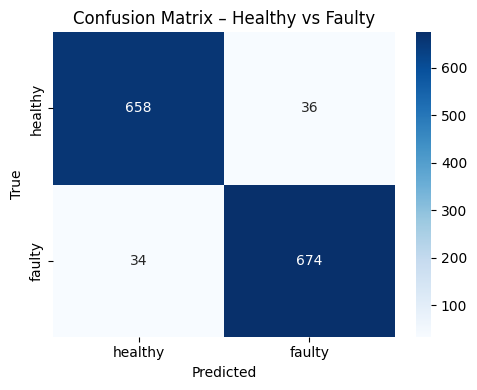

              precision    recall  f1-score   support

     healthy       0.95      0.95      0.95       708
      faulty       0.95      0.95      0.95       694

    accuracy                           0.95      1402
   macro avg       0.95      0.95      0.95      1402
weighted avg       0.95      0.95      0.95      1402



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.makedirs("results", exist_ok=True)

# Ensure test_df has true + pred labels
y_true = test_df["label"]
y_pred = test_df["pred_label"]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["healthy", "faulty"])

plt.figure(figsize=(5, 4))
sns.heatmap(cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["healthy", "faulty"],
            yticklabels=["healthy", "faulty"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Healthy vs Faulty")
plt.tight_layout()
plt.savefig("results/confusion_matrix.png", dpi=200)
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=["healthy", "faulty"])
print(report)

with open("results/classification_report.txt", "w") as f:
    f.write(report)


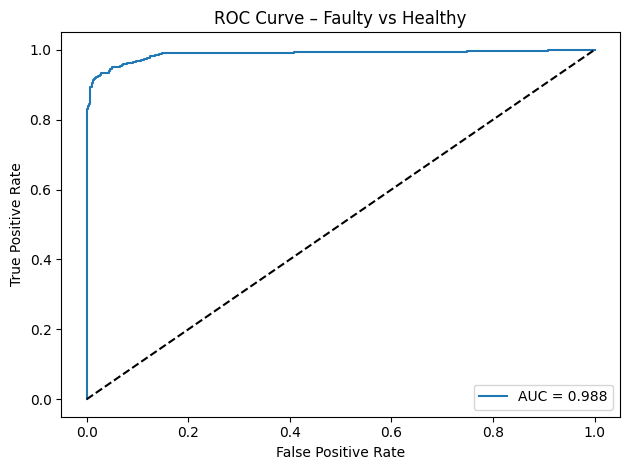

In [25]:
from sklearn.metrics import roc_curve, auc

# Map labels to 0/1
y_true_bin = y_true.map({"healthy": 0, "faulty": 1}).values
y_scores = pred_proba[:, 1]  # probability of 'faulty'

fpr, tpr, _ = roc_curve(y_true_bin, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Faulty vs Healthy")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("results/roc_curve.png", dpi=200)
plt.show()

with open("results/roc_auc.txt", "w") as f:
    f.write(f"AUC: {roc_auc}\n")


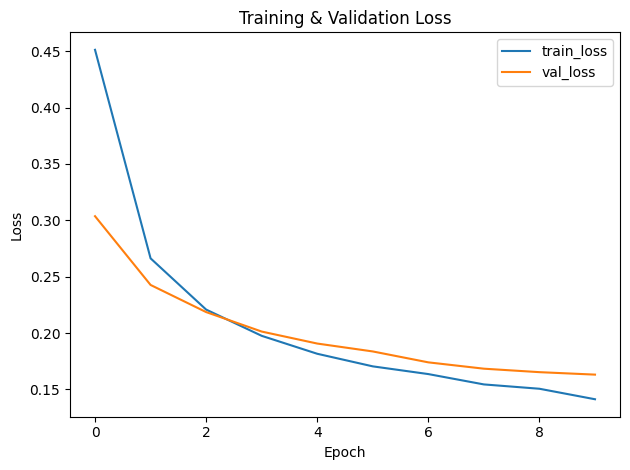

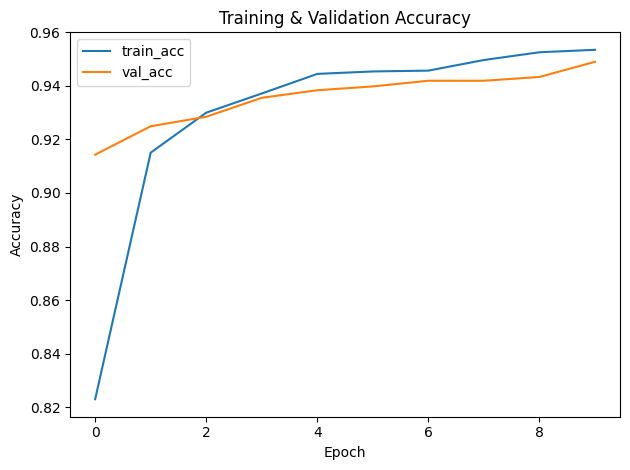

In [26]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("results/loss_curve.png", dpi=200)
plt.show()

# Accuracy curve
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("results/accuracy_curve.png", dpi=200)
plt.show()



In [27]:
from sklearn.metrics import f1_score

snr_levels = ["clean", 30, 20, 10]
snr_metrics = []

for snr in snr_levels:
    subset = test_df[test_df["snr"] == snr]
    if subset.empty:
        continue
    f1 = f1_score(
        subset["label"].map({"healthy": 0, "faulty": 1}),
        subset["pred_label"].map({"healthy": 0, "faulty": 1})
    )
    snr_metrics.append((snr, f1))
    print(f"SNR {snr}: F1 = {f1:.3f}")

with open("results/snr_f1_scores.txt", "w") as f:
    for snr, f1 in snr_metrics:
        f.write(f"SNR {snr}: F1 {f1}\n")


SNR clean: F1 = 0.973


In [5]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [9]:
import os
BASE_DIR = "/content/drive/MyDrive/AeroSound-FaultNet"
os.chdir(BASE_DIR)
print("Working directory:", os.getcwd())

Working directory: /content/drive/MyDrive/AeroSound-FaultNet


In [19]:
from google.colab import files
files.download("scripts/download_data.sh")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
files.download("src/preprocess_all.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
from google.colab import files
files.download("src/predict.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>